## Business Problem - Predict if a customer is going to buy a product next month

In [458]:
#DataPath
datapath = "D:/epsilon/Data.csv"


In [605]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
#, timedelta, date


In [598]:
## ML Libraries

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier


from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, ric_auc_score, roc_curve, classification_report, confusion_matrix


#from sklearn.multioutput import MultiOutputClassifier
#from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.linear_model import LogisticRegression



In [461]:
# Read Data
data = pd.read_csv(datapath)

In [462]:
data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [463]:
data.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [464]:
### Fixing name of customerID - removing space
data = data.rename(columns={'Customer ID': 'CustomerID'})
print(data.columns)


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'CustomerID', 'Country'],
      dtype='object')


In [465]:
## Format Dates Properly
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [466]:
## Get DateRange of the data
print("Minimum date : ", data.InvoiceDate.min())
print("Maximum date : ", data.InvoiceDate.max())


Minimum date :  2009-12-01 07:45:00
Maximum date :  2011-11-09 12:49:00


In [467]:
## Removing Timestamp from the Data
data['VisitDate'] = data['InvoiceDate'].dt.date

In [468]:
data.shape

(944468, 9)

#### Checking to see if there are any extreme outliers in the data 

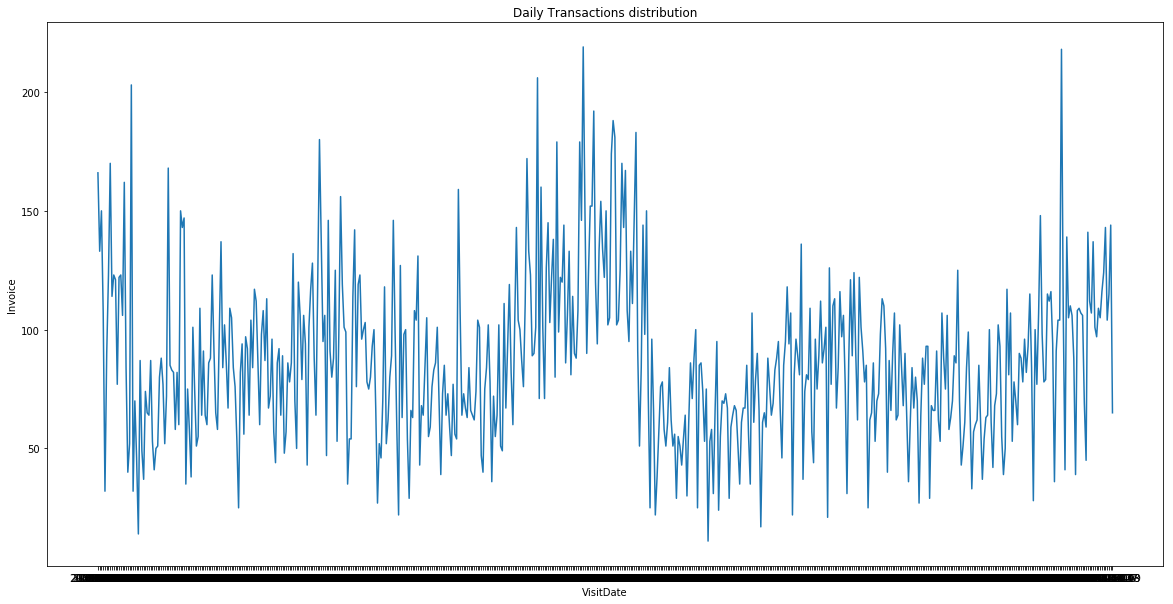

In [39]:
dailybills = data.groupby('VisitDate')['Invoice'].nunique().reset_index()
dailybills['VisitDate']=dailybills['VisitDate'].apply(lambda x: str(x))
plt.figure(figsize=(20, 10))
plt.title('Daily Transactions distribution')
sns.lineplot(x='VisitDate', y='Invoice',data=dailybills)

#### Creating a 'Sales' Column in the data

In [469]:
data['Sales'] = data['Quantity']*data['Price']

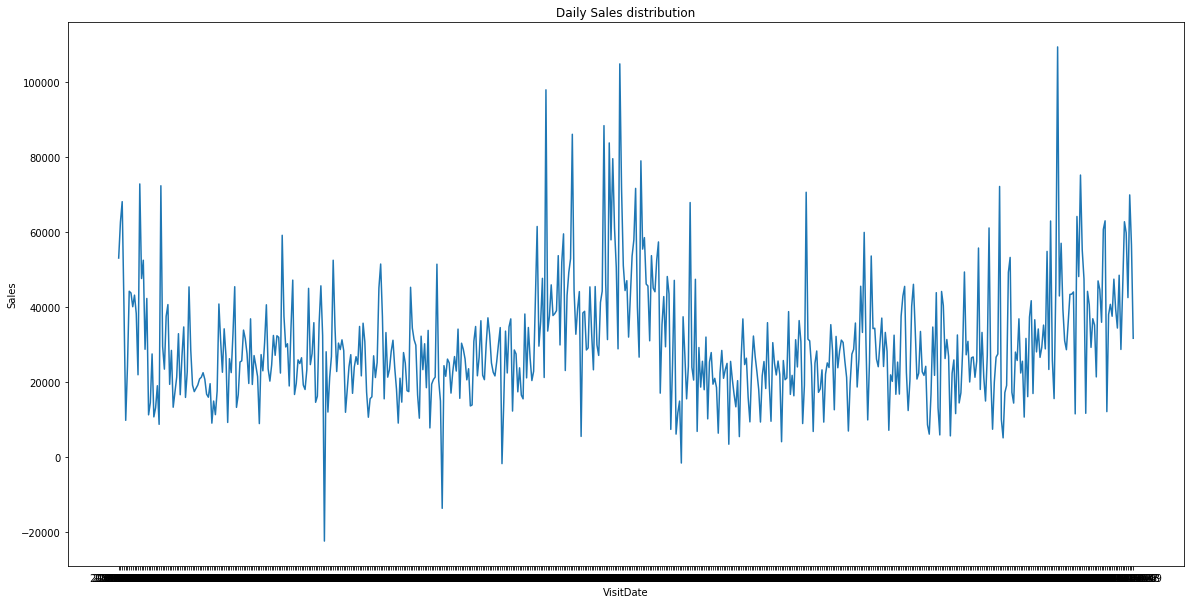

In [41]:
dailysales = data.groupby('VisitDate')['Sales'].sum().reset_index()
dailysales['VisitDate']=dailysales['VisitDate'].apply(lambda x: str(x))
plt.figure(figsize=(20, 10))
plt.title('Daily Sales distribution')
sns.lineplot(x='VisitDate', y='Sales',data=dailysales)
plt.show()

In [611]:
## Percentage of customers
data.Country.value_counts()/data.shape[0]*100


United Kingdom          91.695537
EIRE                     1.733886
Germany                  1.693440
France                   1.323602
Netherlands              0.518281
Spain                    0.368991
Switzerland              0.326110
Belgium                  0.305675
Portugal                 0.244370
Australia                0.196407
Channel Islands          0.172478
Sweden                   0.139867
Italy                    0.138597
Norway                   0.114668
Cyprus                   0.112232
Finland                  0.103127
Austria                  0.091162
Denmark                  0.074433
Unspecified              0.074010
Greece                   0.066387
Japan                    0.055587
Poland                   0.055481
United Arab Emirates     0.052940
USA                      0.052093
Israel                   0.038964
Hong Kong                0.037905
Singapore                0.036634
Malta                    0.029223
Canada                   0.024141
Iceland       

### Prediction Window: November 10 2011 [11/10/2011] to December 9 2011 [12/9/2011]

For Building the model, we will split data in 1 year prior on which we will build the model [developmen window], and use this to predict if the customer is going to purchase next month. There will be an observation window of 1 month for which the actual results will be known

Also, this model, once built will be used to score the 1 year data prior to November 9, 2011 (Cutoff date) and predict the purchase probability of customers next month (11/10/2011 to 12/9/2011)

#### Development Window: 9th October 2010 [2009-10-09] to 9th October 2011 [2011-10-09] {2 years}
#### Observation Window: 10th October 2011 [2011-10-10] to 9th November 2011 [2011-11-09] {1 month}

In [613]:
data_2y = data[(data.InvoiceDate<date(2011,10,9)) & (data.InvoiceDate>=date(2009,10,9))].reset_index()
data_next = data[(data.InvoiceDate>=date(2011,10,10)) & (data.InvoiceDate<date(2011,11,9))].reset_index()

In [614]:
## Building a Single View at user level
user = pd.DataFrame(data_2y['CustomerID'].unique())
user.columns=['CustomerID']

In [615]:
user.shape

(5562, 1)

By using the data in tx_next, we need to calculate our label (days between last purchase before cutoff date and first purchase after that)

In [616]:
## dataframe with customer ID and first purchase date in tx_next
data_next_first_purchase = data_next.groupby('CustomerID').InvoiceDate.min().reset_index()
data_next_first_purchase.columns = ['CustomerID','MinPurchaseDate']

## dataframe with customer ID and first purchase date in tx_next
data_last_purchase = data_next.groupby('CustomerID').InvoiceDate.max().reset_index()
data_last_purchase.columns = ['CustomerID','MaxPurchaseDate']


#Merge two dataframes
data_purchase_dates = pd.merge(data_last_purchase, data_next_first_purchase, on='CustomerID', how='left')

#Calculate the time difference in days:
data_purchase_dates['NextPurchaseDay'] = (data_purchase_dates['MaxPurchaseDate'] - data_purchase_dates['MinPurchaseDate']).dt.days

#Merge with user
user = pd.merge(user, data_purchase_dates[['CustomerID', 'NextPurchaseDay']], on='CustomerID', how='left')

user.fillna(999, inplace=True)

In [617]:
user.head(20)

,CustomerID,NextPurchaseDay
0,13085.0,999.0
1,13078.0,27.0
2,15362.0,999.0
3,18102.0,13.0
4,12682.0,22.0
5,18087.0,999.0
6,13635.0,999.0
7,14110.0,6.0
8,12636.0,999.0
9,17519.0,999.0


### RFM Features

In [618]:
# Order Cluster Method
## Function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name, df, ascending):
    new_cluster_field_name = 'new_'+cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name, ascending = ascending).reset_index(drop=True)
    df_new['index']=df_new.index
    df_final = pd.merge(df, df_new[[cluster_field_name, 'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name], axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

#### Recency

In [619]:
#Get the max purchase date
maxDate = data_2y.groupby('CustomerID')['InvoiceDate'].max().reset_index()
maxDate.columns = ['CustomerID','MaxPurchaseDate']

#Calculate recency based on the max invoice date as the last date
maxDate['Recency'] = (maxDate['MaxPurchaseDate'].max()-maxDate['MaxPurchaseDate']).dt.days
user = pd.merge(user, maxDate[['CustomerID','Recency']], on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Recency']])
user['RecencyCluster']=kmeans.predict(user[['Recency']])
user = order_cluster('RecencyCluster','Recency', user, False)


In [620]:
user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster
0,13085.0,999.0,94,3
1,13078.0,27.0,1,3
2,18102.0,13.0,3,3
3,12682.0,22.0,18,3
4,18087.0,999.0,35,3


#### Frequency

In [621]:
#Get just the date from InvoiceDate
data_2y['VisitDate'] = data_2y['InvoiceDate'].dt.date
freq = data_2y.groupby('CustomerID').VisitDate.count().reset_index()
freq.columns = ['CustomerID', 'Frequency']

# Add this to user
user = pd.merge(user, freq, on='CustomerID')



kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Frequency']])
user['FrequencyCluster']=kmeans.predict(user[['Frequency']])
user = order_cluster('FrequencyCluster','Frequency', user, True)

In [622]:
user.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,13085.0,999.0,94,3,92,0
1,18087.0,999.0,35,3,95,0
2,13635.0,999.0,4,3,167,0
3,17519.0,999.0,70,3,190,0
4,12362.0,23.0,9,3,151,0


#### Monetary

In [623]:
monetary = data_2y.groupby('CustomerID')['Sales'].sum().reset_index()
user = pd.merge(user, monetary, on='CustomerID')


kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Sales']])
user['MonetaryCluster']=kmeans.predict(user[['Sales']])
user = order_cluster('MonetaryCluster','Sales', user, True)

In [624]:
user.MonetaryCluster.value_counts()

0    5501
1      51
2       7
3       2
Name: MonetaryCluster, dtype: int64

In [625]:
user['OverallScore']= user['RecencyCluster']+user['FrequencyCluster']+user['MonetaryCluster']
user['Segment'] = 'LowValue'
user.loc[user['OverallScore']>2,'Segment']='MidValue'
user.loc[user['OverallScore']>4,'Segment']='HighValue'

In [626]:
user.groupby('OverallScore')['Recency','Frequency','Sales'].mean()

,Recency,Frequency,Sales
OverallScore,,,
0,557.466300,24.178817,282.968063
1,347.809274,51.662678,777.137533
2,170.323689,71.962025,1217.840380
3,35.684870,109.843687,2218.702590
4,24.334286,588.831429,9454.859577
5,19.107143,1030.107143,38139.578679
6,8.333333,2529.583333,101410.954167
7,3.333333,4979.333333,283767.260000
8,0.500000,6404.000000,333630.860000


### Adding  Days between last 3 purchases

First we create a dataframe with customer ID and Invoice Day (not datetime). Then we will remove the duplicates since customers can do multiple purchases in a day and difference will become0 of those days 

In [627]:
# Create a datafram with CustomerID and Invoice Date
data_day_order = data_2y[['CustomerID', 'InvoiceDate']]

## Convert Invoice datetime to day
data_day_order['InvoiceDay'] = data_2y['InvoiceDate'].dt.date

data_day_order= data_day_order.sort_values(['CustomerID', 'InvoiceDate'])

#drop duplicates
data_day_order = data_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

In [628]:
## Using Shift to create new columns with the dates of last 3 purchases 

data_day_order['PrevInvoiceDate'] = data_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
data_day_order['T2InvoiceDate'] = data_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
data_day_order['T3InvoiceDate'] = data_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

In [629]:
data_day_order.head(20)

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate
27657,12346.0,2009-12-14 08:34:00,2009-12-14,NaN,NaN,NaN
38938,12346.0,2009-12-18 10:47:00,2009-12-18,2009-12-14,NaN,NaN
44722,12346.0,2010-01-04 09:24:00,2010-01-04,2009-12-18,2009-12-14,NaN
55536,12346.0,2010-01-14 13:50:00,2010-01-14,2010-01-04,2009-12-18,2009-12-14
65381,12346.0,2010-01-22 13:30:00,2010-01-22,2010-01-14,2010-01-04,2009-12-18
70304,12346.0,2010-01-26 17:27:00,2010-01-26,2010-01-22,2010-01-14,2010-01-04
106632,12346.0,2010-03-02 13:08:00,2010-03-02,2010-01-26,2010-01-22,2010-01-14
250035,12346.0,2010-06-28 13:53:00,2010-06-28,2010-03-02,2010-01-26,2010-01-22
252571,12346.0,2010-06-30 11:22:00,2010-06-30,2010-06-28,2010-03-02,2010-01-26
365675,12346.0,2010-10-04 09:54:00,2010-10-04,2010-06-30,2010-06-28,2010-03-02


In [630]:
### Calculate Day difference
data_day_order['DayDiff']= (data_day_order['InvoiceDay']-data_day_order['PrevInvoiceDate']).dt.days
data_day_order['DayDiff2']= (data_day_order['InvoiceDay']-data_day_order['T2InvoiceDate']).dt.days
data_day_order['DayDiff3']= (data_day_order['InvoiceDay']-data_day_order['T3InvoiceDate']).dt.days

In [631]:
data_day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
27657,12346.0,2009-12-14 08:34:00,2009-12-14,NaN,NaN,NaN,NaN,NaN,NaN
38938,12346.0,2009-12-18 10:47:00,2009-12-18,2009-12-14,NaN,NaN,4.0,NaN,NaN
44722,12346.0,2010-01-04 09:24:00,2010-01-04,2009-12-18,2009-12-14,NaN,17.0,21.0,NaN
55536,12346.0,2010-01-14 13:50:00,2010-01-14,2010-01-04,2009-12-18,2009-12-14,10.0,27.0,31.0
65381,12346.0,2010-01-22 13:30:00,2010-01-22,2010-01-14,2010-01-04,2009-12-18,8.0,18.0,35.0


In [632]:
#For each customer, we utilize .agg() method to find out the mean and stddev of the difference butween purchase in days
mean = data_day_order.groupby('CustomerID')['DayDiff'].mean().reset_index()
std = data_day_order.groupby('CustomerID')['DayDiff'].std().reset_index()

In [633]:
df_mean = pd.DataFrame(mean)
df_mean.columns=['CustomerID','mean']
df_std = pd.DataFrame(std)
df_std.columns=['CustomerID','std']

In [634]:
df = pd.merge(df_mean, df_std, on='CustomerID')

In [636]:
##Keeping customers with >3 purchases
data_day_order_last = data_day_order.drop_duplicates(subset=['CustomerID'],keep='last')

In [637]:
data_day_order_last = data_day_order_last.dropna()
data_day_order_last = pd.merge(data_day_order_last, df, on='CustomerID')

In [638]:
user= pd.merge(user, data_day_order_last[['CustomerID', 'DayDiff','DayDiff2','DayDiff3','mean','std']], on='CustomerID')

In [639]:
user.head(20)

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Sales,MonetaryCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,mean,std
0,13085.0,999.0,94,3,92,0,1459.46,0,3,MidValue,68.0,138.0,263.0,96.833333,88.569558
1,18087.0,999.0,35,3,95,0,14411.62,0,3,MidValue,46.0,192.0,203.0,40.000000,40.733279
2,13635.0,999.0,4,3,167,0,2948.22,0,3,MidValue,370.0,375.0,650.0,134.200000,175.176197
3,17519.0,999.0,70,3,190,0,4411.48,0,3,MidValue,40.0,73.0,128.0,40.333333,26.596634
4,12362.0,23.0,9,3,151,0,2684.54,0,3,MidValue,40.0,48.0,83.0,95.142857,155.290511
5,16321.0,999.0,9,3,36,0,265.50,0,3,MidValue,233.0,251.0,554.0,166.500000,126.592522
6,15712.0,999.0,8,3,156,0,3261.01,0,3,MidValue,38.0,112.0,216.0,60.636364,37.855707
7,17700.0,999.0,31,3,317,0,5787.91,0,3,MidValue,112.0,119.0,187.0,46.000000,30.839535
8,16128.0,0.0,14,3,173,0,3280.24,0,3,MidValue,66.0,205.0,303.0,66.100000,72.549523
9,17984.0,999.0,82,3,242,0,1152.19,0,3,MidValue,247.0,251.0,350.0,148.250000,118.269114


In [641]:
## Create tx_class as a copy of tx_user before applying get_dummies
data_cleaned = user.copy()
data_cleaned = data_cleaned[data_cleaned['NextPurchaseDay']!=999]
data_cleaned = pd.get_dummies(data_cleaned)
data_cleaned.head()

,CustomerID,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Sales,MonetaryCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,mean,std,Segment_HighValue,Segment_LowValue,Segment_MidValue
4,12362.0,23.0,9,3,151,0,2684.54,0,3,40.0,48.0,83.0,95.142857,155.290511,0,0,1
8,16128.0,0.0,14,3,173,0,3280.24,0,3,66.0,205.0,303.0,66.100000,72.549523,0,0,1
11,12615.0,0.0,8,3,233,0,4485.08,0,3,97.0,342.0,384.0,95.285714,77.155070,0,0,1
14,15091.0,0.0,4,3,59,0,1026.86,0,3,404.0,607.0,671.0,223.666667,170.939560,0,0,1
15,14292.0,4.0,23,3,186,0,7161.62,0,3,2.0,59.0,99.0,36.222222,32.202586,0,0,1


## Build a Machine Learning Model 

In [642]:
### Building Output Class
data_cleaned['NextPurchaseDayRange']=1
data_cleaned.loc[data_cleaned.NextPurchaseDay==0,'NextPurchaseDayRange']=0

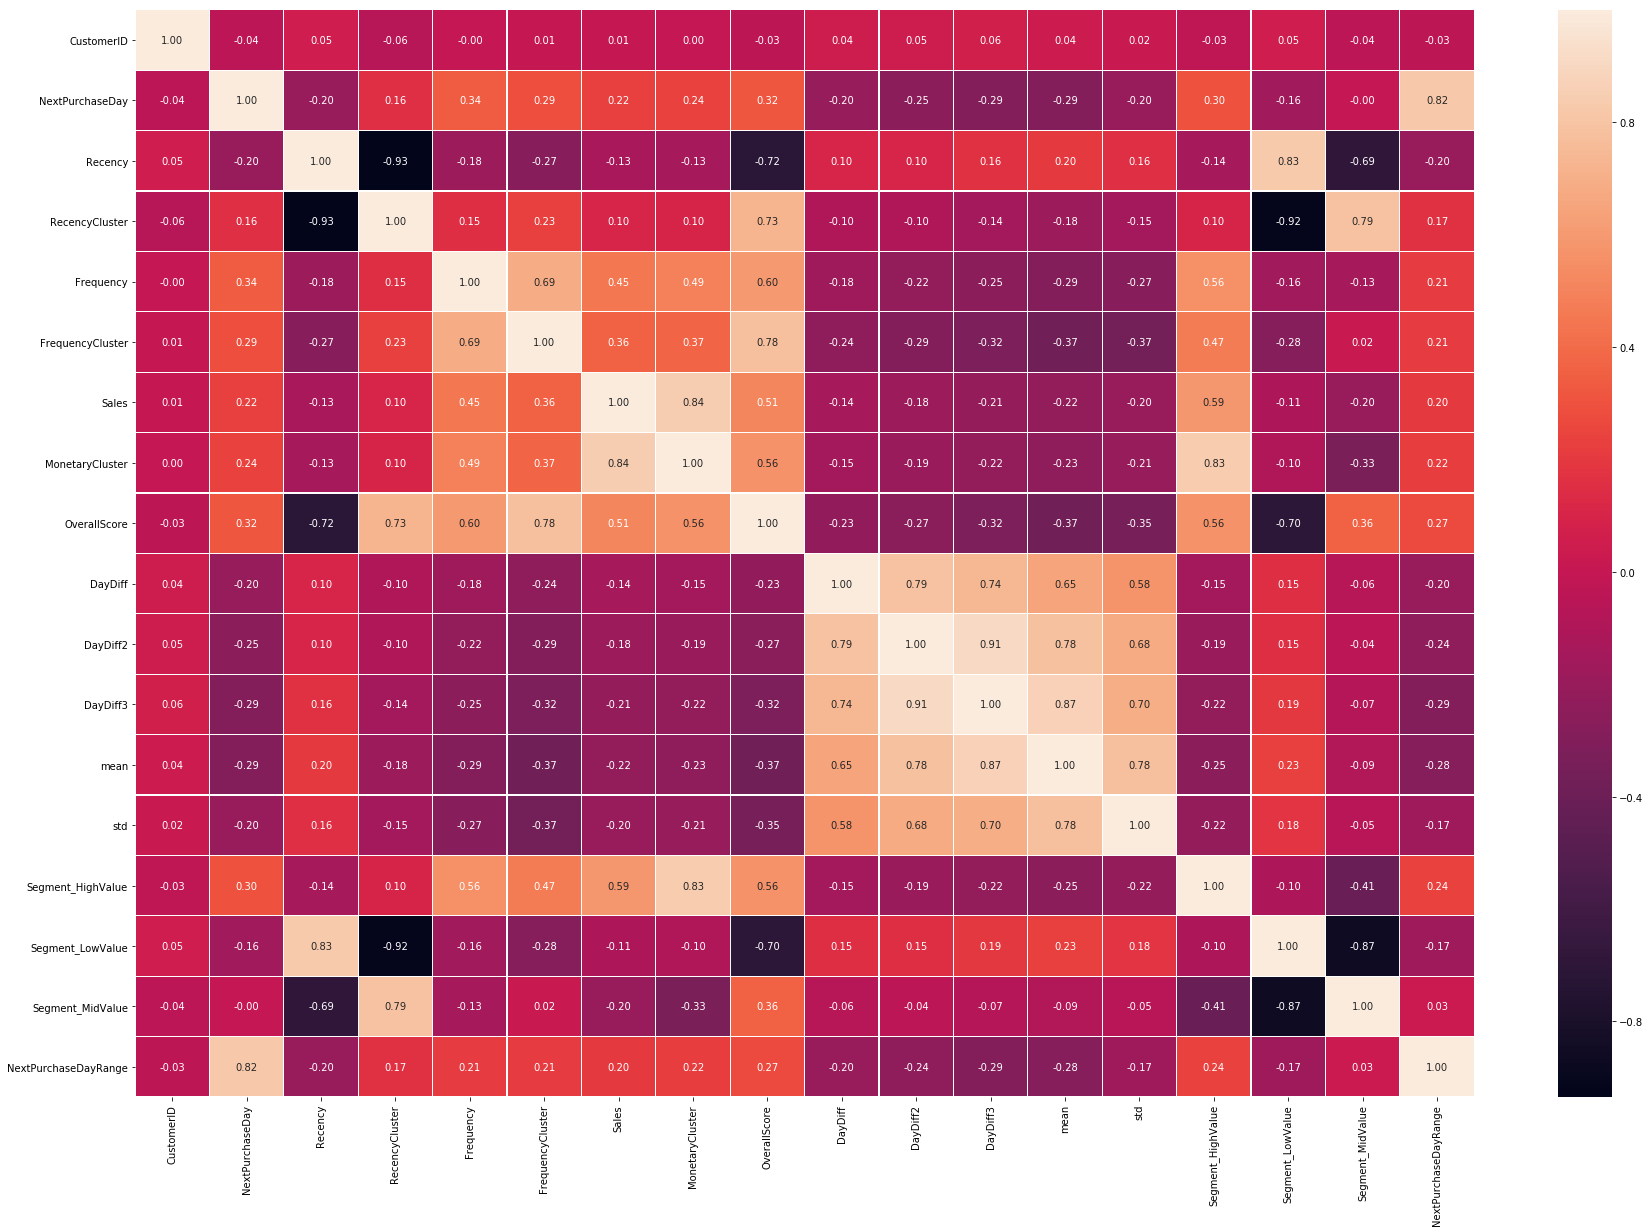

In [643]:
## Correlation betweeen features and labels
corr = data_cleaned[data_cleaned.columns].corr()
plt.figure(figsize=(30,20))
sns.heatmap(corr, annot=True, linewidths = 0.2, fmt='.2f')

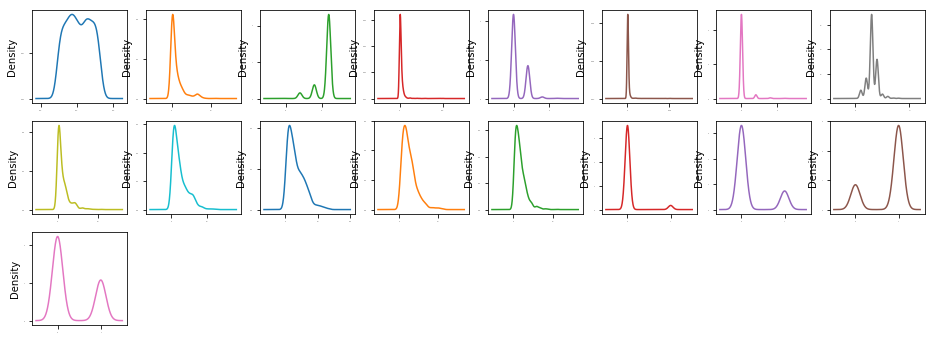

In [661]:
data_cleaned.plot(kind='density', subplots=True, figsize=(16,16), layout=(8,8), sharex=False, legend=False, fontsize=1)
plt.show()

#### The chart above shows the data distribution of each variable. To improve the accuracy, each variable needs to be studied in isolation to ensure curve is normal

In [644]:
data_cleaned = data_cleaned.drop('NextPurchaseDay', axis=1)

In [645]:
X,y = data_cleaned.drop('NextPurchaseDayRange',axis=1), data_cleaned.NextPurchaseDayRange


In [646]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

## Running Models using Stratified KFOLD strategy to account for sample bias in the data

In [647]:
## Test Option and evaluation metrics
NUM_FOLDS = 10
SEED = 42
SCORING = 'accuracy'

#### Building Model Arrays for evaluating Multiple Models at once

In [658]:
models = []
models.append(("Logistic Regression",LogisticRegression()))
models.append(("Lin Discriminant Analysis",LinearDiscriminantAnalysis()))
models.append(("eXtreme Grad Boosting",xgb.XGBClassifier()))
models.append(("Naive Bayes",GaussianNB()))
models.append(("Neural Network",MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)))
models.append(("Random Forest",RandomForestClassifier()))
models.append(("Support Vector",SVC()))
models.append(("Decision Tree",DecisionTreeClassifier()))
models.append(("K-Nearest Neighbor",KNeighborsClassifier()))

In [692]:
modelresults=[]
names=[]

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=NUM_FOLDS, random_state=SEED)
    cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = SCORING)
    modelresults.append(cv_result)
    names.append(name)
    msg = "%s: %f (%f)" %(name, cv_result.mean(), cv_result.std())
    print(msg)

Logistic Regression: 0.718056 (0.037294)
Lin Discriminant Analysis: 0.715278 (0.049398)
eXtreme Grad Boosting: 0.672222 (0.047791)
Naive Bayes: 0.711111 (0.044704)
Neural Network: 0.708333 (0.048908)
Random Forest: 0.690278 (0.048133)
Support Vector: 0.676389 (0.041225)
Decision Tree: 0.625000 (0.044790)
K-Nearest Neighbor: 0.648611 (0.062746)


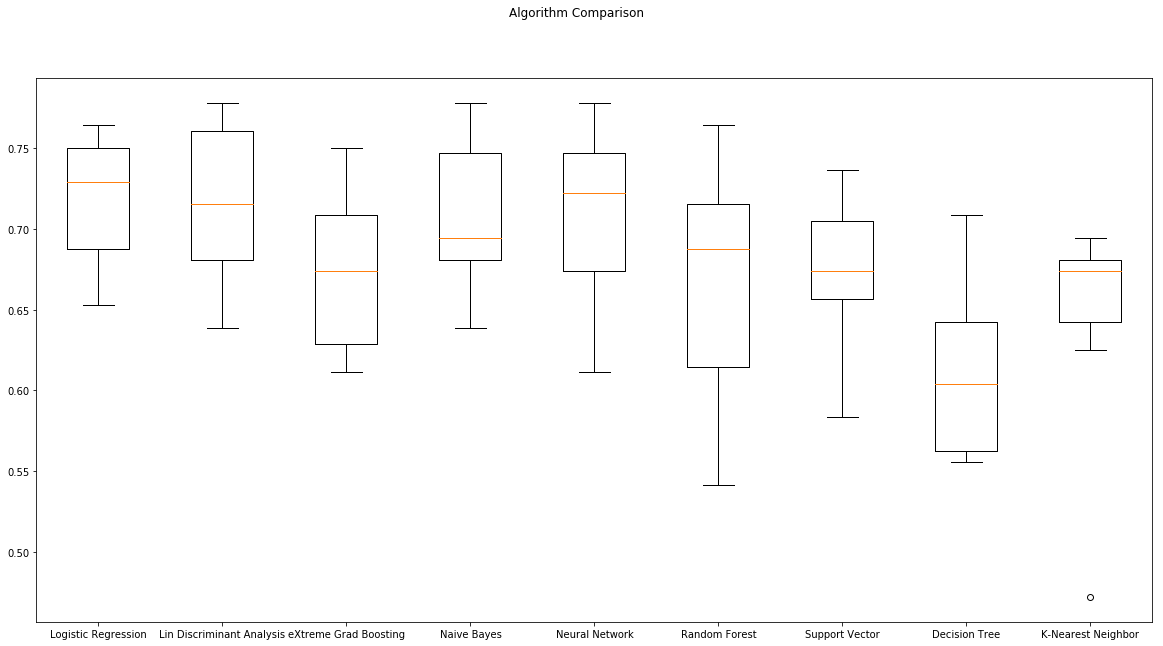

In [660]:
# Compare Algorithms
fig = plt.figure(figsize=(20,10))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(modelresults)
ax.set_xticklabels(names)
plt.show()

### Logistic Regression Models show the best accuracy amon all selected models.

#### Standardizing the dataset - Normalization

In [700]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [701]:
#Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()),('LDA', KNeighborsClassifier())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', LogisticRegression())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))

In [702]:

results = []
names=[]
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: 0.705556 (0.052264)
ScaledLDA: 0.670833 (0.060237)
ScaledKNN: 0.719444 (0.050766)
ScaledCART: 0.601389 (0.044812)
ScaledNB: 0.708333 (0.042127)
ScaledSVM: 0.716667 (0.056314)


#### Standardizing the data improves the accuracy by just a fraction, hence will not be proceeding with this. Although the data should always be standardized either by MinMAxScaler or StandardScaler



## Ensemble Methods

In [694]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
# ensembles
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.698611 (0.053088)
GBM: 0.691667 (0.054078)
RF: 0.693056 (0.040943)
ET: 0.675000 (0.040825)


#### The Ensemble methods do not provide an accuracy improvement over Logistic Regression, hence will not pr proceeding with them 

### Finetuning Logistic Regression Model

In [706]:
from sklearn.linear_model import LogisticRegression, Ridge, Lasso

In [707]:
model = LogisticRegression()
cv_result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")

In [708]:
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [665]:
y_pred= model.predict(X_test)
y_prob = model.predict_proba(X_test)

In [666]:
y = y_prob[:,1]

In [667]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y)

0.7394444444444443

In [668]:
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import accuracy_score

In [669]:
confusion_matrix(y_test, y_pred)

array([[110,  10],
       [ 43,  17]], dtype=int64)

In [670]:
accuracy_score(y_test, y_pred)

0.7055555555555556

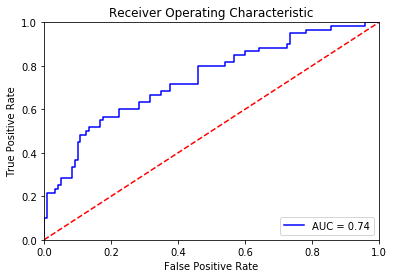

In [671]:
from sklearn import metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, y_prob[:,1])
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


### Using Randomized Grid Search for optimizing the model hyperparameters

In [681]:
from sklearn.linear_model import SGDClassifier
#logistic = LogisticRegression(solver='liblinear')
sgd = SGDClassifier()

In [684]:
from sklearn.model_selection import RandomizedSearchCV
loss = ['hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron']
penalty = ['l1', 'l2', 'elasticnet']
alpha = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
learning_rate = ['constant', 'optimal', 'invscaling', 'adaptive']
class_weight = [{1:0.5, 0:0.5}, {1:0.4, 0:0.6}, {1:0.6, 0:0.4}, {1:0.7, 0:0.3}]
eta0 = [1, 10, 100]

param_distributions = dict(loss=loss,
                           penalty=penalty,
                           alpha=alpha,
                           class_weight=class_weight,
                           eta0=eta0)

random = RandomizedSearchCV(estimator=sgd,
                            param_distributions=param_distributions,
                            scoring='roc_auc',
                            verbose=1, n_jobs=-1,
                            n_iter=1000)
random_result = random.fit(X_train, y_train)

print('Best Score: ', random_result.best_score_)
print('Best Params: ', random_result.best_params_)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Done 344 tasks      | elapsed:    2.7s


Best Score:  0.6878885018334859
Best Params:  {'penalty': 'elasticnet', 'loss': 'hinge', 'eta0': 1, 'class_weight': {1: 0.5, 0: 0.5}, 'alpha': 10}


[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed:    5.7s finished


In [689]:
modelTuned = SGDClassifier(loss='hinge', penalty='elasticnet',eta0=1, alpha=10, class_weight={1:0.5,0:0.5})

In [691]:
modelTuned.fit(X_train, y_train)
y_pred_tuned= modelTuned.predict(X_test)
#y_prob_tuned = modelTuned.predict_proba(X_test)[:,1]
#print("ROC AUC Score: ",roc_auc_score(y_test, y_prob_tuned))
print("Accuracy Score: ",accuracy_score(y_test, y_pred_tuned))

Accuracy Score:  0.6666666666666666


#### The tuned model accuracy is not better than the Logistic Regression Model, hence we will finalize the Logistic Regression Model 

## Fitting the model on the data From 9th Nov 2010 to 9th Nov 2011[1 year], and Predicting from 10th Nov 2011 to 9th Dec 2011 [1 Month]

In [531]:
data = pd.read_csv(datapath)

In [532]:
### Fixing name of customerID - removing space
data = data.rename(columns={'Customer ID': 'CustomerID'})
print(data.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'CustomerID', 'Country'],
      dtype='object')


In [533]:
## Format Dates Properly
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [534]:
data['VisitDate'] = data['InvoiceDate'].dt.date

In [535]:
data['Sales'] = data['Quantity']*data['Price']

In [536]:
#tx_1y = data[(data.InvoiceDate<date(2011,1,9)) & (data.InvoiceDate>=date(2009,12,1))].reset_index()
tx_all = data.copy()
## Building a Single View at user level
user = pd.DataFrame(tx_1y['CustomerID'].unique())
user.columns=['CustomerID']

In [537]:
user.CustomerID.nunique()

5780

#### Recency

In [538]:
#Get the max purchase date
maxDate = tx_all.groupby('CustomerID')['InvoiceDate'].max().reset_index()
maxDate.columns = ['CustomerID','MaxPurchaseDate']

#Calculate recency based on the max invoice date as the last date
maxDate['Recency'] = (maxDate['MaxPurchaseDate'].max()-maxDate['MaxPurchaseDate']).dt.days
user = pd.merge(user, maxDate[['CustomerID','Recency']], on='CustomerID')

kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Recency']])
user['RecencyCluster']=kmeans.predict(user[['Recency']])
user = order_cluster('RecencyCluster','Recency', user, False)

#### Frequency

In [539]:
#Get just the date from InvoiceDate
tx_all['VisitDate'] = tx_all['InvoiceDate'].dt.date
freq = tx_all.groupby('CustomerID').VisitDate.count().reset_index()
freq.columns = ['CustomerID', 'Frequency']

# Add this to user
user = pd.merge(user, freq, on='CustomerID')



kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Frequency']])
user['FrequencyCluster']=kmeans.predict(user[['Frequency']])
user = order_cluster('FrequencyCluster','Frequency', user, True)

#### Monetary

In [540]:
monetary = tx_all.groupby('CustomerID')['Sales'].sum().reset_index()
user = pd.merge(user, monetary, on='CustomerID')


kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Sales']])
user['MonetaryCluster']=kmeans.predict(user[['Sales']])
user = order_cluster('MonetaryCluster','Sales', user, True)

In [541]:
user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Sales,MonetaryCluster
0,13085.0,127,2,92,0,1459.46,0
1,16714.0,188,2,114,0,1222.24,0
2,17984.0,114,2,242,0,1152.19,0
3,14871.0,147,2,159,0,1062.19,0
4,12913.0,252,2,57,0,4666.00,0


In [542]:
user['OverallScore']= user['RecencyCluster']+user['FrequencyCluster']+user['MonetaryCluster']
user['Segment'] = 'LowValue'
user.loc[user['OverallScore']>2,'Segment']='MidValue'
user.loc[user['OverallScore']>4,'Segment']='HighValue'



In [543]:
# Create a datafram with CustomerID and Invoice Date
tx_day_order = tx_all[['CustomerID', 'InvoiceDate']]

## Convert Invoice datetime to day
tx_day_order['InvoiceDay'] = tx_all['InvoiceDate'].dt.date

tx_day_order= tx_day_order.sort_values(['CustomerID', 'InvoiceDate'])

#drop duplicates
tx_day_order = tx_day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

In [544]:
## Using Shift to create new columns with the dates of last 3 purchases 

tx_day_order['PrevInvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
tx_day_order['T2InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
tx_day_order['T3InvoiceDate'] = tx_day_order.groupby('CustomerID')['InvoiceDay'].shift(3)

In [545]:
### Calculate Day difference
tx_day_order['DayDiff']= (tx_day_order['InvoiceDay']-tx_day_order['PrevInvoiceDate']).dt.days
tx_day_order['DayDiff2']= (tx_day_order['InvoiceDay']-tx_day_order['T2InvoiceDate']).dt.days
tx_day_order['DayDiff3']= (tx_day_order['InvoiceDay']-tx_day_order['T3InvoiceDate']).dt.days

In [546]:
tx_day_order.head()

,CustomerID,InvoiceDate,InvoiceDay,PrevInvoiceDate,T2InvoiceDate,T3InvoiceDate,DayDiff,DayDiff2,DayDiff3
27657,12346.0,2009-12-14 08:34:00,2009-12-14,NaN,NaN,NaN,NaN,NaN,NaN
38938,12346.0,2009-12-18 10:47:00,2009-12-18,2009-12-14,NaN,NaN,4.0,NaN,NaN
44722,12346.0,2010-01-04 09:24:00,2010-01-04,2009-12-18,2009-12-14,NaN,17.0,21.0,NaN
55536,12346.0,2010-01-14 13:50:00,2010-01-14,2010-01-04,2009-12-18,2009-12-14,10.0,27.0,31.0
65381,12346.0,2010-01-22 13:30:00,2010-01-22,2010-01-14,2010-01-04,2009-12-18,8.0,18.0,35.0


In [547]:
#For each customer, we utilize .agg() method to find out the mean and stddev of the difference butween purchase in days
mean = tx_day_order.groupby('CustomerID')['DayDiff'].mean().reset_index()
std = tx_day_order.groupby('CustomerID')['DayDiff'].std().reset_index()
df_mean = pd.DataFrame(mean)
df_mean.columns=['CustomerID','mean']
df_std = pd.DataFrame(std)
df_std.columns=['CustomerID','std']

df = pd.merge(df_mean, df_std, on='CustomerID')

In [548]:
##Keeping customers with >3 purchases un user_warm and all transactions in users_all
tx_day_order_last = tx_day_order.drop_duplicates(subset=['CustomerID'],keep='last')
tx_day_order_last = tx_day_order_last.dropna()
tx_day_order_last = pd.merge(tx_day_order_last, df, on='CustomerID')

### Warm Users: Customers who have atleast 3 or more purchases, model will be more accurate for them
user_warm= pd.merge(user, tx_day_order_last[['CustomerID', 'DayDiff','DayDiff2','DayDiff3','mean','std']], on='CustomerID')

### Cole Users: Customers who have just 1 or 2 or 3 purchases, mnoel will be less accurate for them
user_all= pd.merge(user, tx_day_order_last[['CustomerID', 'DayDiff','DayDiff2','DayDiff3','mean','std']], on='CustomerID', how='left')

In [550]:
user_warm.head(30)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Sales,MonetaryCluster,OverallScore,Segment,DayDiff,DayDiff2,DayDiff3,mean,std
0,13085.0,127,2,92,0,1459.46,0,2,LowValue,68.0,138.0,263.0,96.833333,88.569558
1,16714.0,188,2,114,0,1222.24,0,2,LowValue,99.0,441.0,452.0,130.000000,145.956615
2,17984.0,114,2,242,0,1152.19,0,2,LowValue,247.0,251.0,350.0,148.250000,118.269114
3,14871.0,147,2,159,0,1062.19,0,2,LowValue,77.0,182.0,315.0,80.000000,38.888730
4,12913.0,252,2,57,0,4666.00,0,2,LowValue,19.0,86.0,98.0,45.600000,47.893864
5,16955.0,154,2,53,0,1072.06,0,2,LowValue,152.0,176.0,184.0,69.250000,71.971721
6,18037.0,123,2,33,0,167.42,0,2,LowValue,71.0,82.0,99.0,44.923077,35.110448
7,13711.0,188,2,103,0,1632.61,0,2,LowValue,188.0,342.0,356.0,43.333333,61.530973
8,16620.0,230,2,90,0,1675.73,0,2,LowValue,129.0,302.0,384.0,119.500000,40.861555
9,13819.0,271,2,104,0,2631.10,0,2,LowValue,8.0,18.0,368.0,87.400000,148.367112


In [551]:
user_warm.CustomerID.nunique()

2658

In [552]:
## Create tx_class as a copy of tx_user before applying get_dummies
X_warm = user_warm.copy()
X_warm = pd.get_dummies(X_warm)
X_warm.head(20)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Sales,MonetaryCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,mean,std,Segment_HighValue,Segment_LowValue,Segment_MidValue
0,13085.0,127,2,92,0,1459.46,0,2,68.0,138.0,263.0,96.833333,88.569558,0,1,0
1,16714.0,188,2,114,0,1222.24,0,2,99.0,441.0,452.0,130.000000,145.956615,0,1,0
2,17984.0,114,2,242,0,1152.19,0,2,247.0,251.0,350.0,148.250000,118.269114,0,1,0
3,14871.0,147,2,159,0,1062.19,0,2,77.0,182.0,315.0,80.000000,38.888730,0,1,0
4,12913.0,252,2,57,0,4666.00,0,2,19.0,86.0,98.0,45.600000,47.893864,0,1,0
5,16955.0,154,2,53,0,1072.06,0,2,152.0,176.0,184.0,69.250000,71.971721,0,1,0
6,18037.0,123,2,33,0,167.42,0,2,71.0,82.0,99.0,44.923077,35.110448,0,1,0
7,13711.0,188,2,103,0,1632.61,0,2,188.0,342.0,356.0,43.333333,61.530973,0,1,0
8,16620.0,230,2,90,0,1675.73,0,2,129.0,302.0,384.0,119.500000,40.861555,0,1,0
9,13819.0,271,2,104,0,2631.10,0,2,8.0,18.0,368.0,87.400000,148.367112,0,1,0


In [553]:
X_warm.CustomerID.nunique()

2658

In [554]:
y=model.predict(X_warm)

In [555]:
y_probability = model.predict_proba(X_warm)

In [556]:
THRESHOLD = 0.35
y_threshold = np.where(model.predict_proba(X_warm)[:,1] > THRESHOLD, 1, 0)

### Convert Results to DataFrame for Export


In [558]:
results = pd.DataFrame()
results['CustomerID']= X_warm['CustomerID']

In [559]:
results['Prediction'] = pd.DataFrame(data=y_probability[:,1])

In [560]:
results.to_csv('D:/epsilon/submission_warm_users.csv', index=None)

In [561]:
results['Class'] = pd.DataFrame(data=y)

In [562]:
results.to_csv('D:/epsilon/submission_warm_users_withClass.csv', index=None)

# All Users

In [563]:
X_all = user_all.copy()
X_all = pd.get_dummies(X_all)
X_all.head(10)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Sales,MonetaryCluster,OverallScore,DayDiff,DayDiff2,DayDiff3,mean,std,Segment_HighValue,Segment_LowValue,Segment_MidValue
0,13085.0,127,2,92,0,1459.46,0,2,68.0,138.0,263.0,96.833333,88.569558,0,1,0
1,16714.0,188,2,114,0,1222.24,0,2,99.0,441.0,452.0,130.000000,145.956615,0,1,0
2,17984.0,114,2,242,0,1152.19,0,2,247.0,251.0,350.0,148.250000,118.269114,0,1,0
3,14871.0,147,2,159,0,1062.19,0,2,77.0,182.0,315.0,80.000000,38.888730,0,1,0
4,12913.0,252,2,57,0,4666.00,0,2,19.0,86.0,98.0,45.600000,47.893864,0,1,0
5,16955.0,154,2,53,0,1072.06,0,2,152.0,176.0,184.0,69.250000,71.971721,0,1,0
6,18037.0,123,2,33,0,167.42,0,2,71.0,82.0,99.0,44.923077,35.110448,0,1,0
7,13711.0,188,2,103,0,1632.61,0,2,188.0,342.0,356.0,43.333333,61.530973,0,1,0
8,16620.0,230,2,90,0,1675.73,0,2,129.0,302.0,384.0,119.500000,40.861555,0,1,0
9,16763.0,154,2,45,0,947.75,0,2,NaN,NaN,NaN,NaN,NaN,0,1,0


### Missing Value Imputation

In [565]:
X_all.isnull().sum()

CustomerID              0
Recency                 0
RecencyCluster          0
Frequency               0
FrequencyCluster        0
Sales                   0
MonetaryCluster         0
OverallScore            0
DayDiff              3122
DayDiff2             3122
DayDiff3             3122
mean                 3122
std                  3122
Segment_HighValue       0
Segment_LowValue        0
Segment_MidValue        0
dtype: int64

In [566]:
X_all['DayDiff'].fillna(X_all['DayDiff'].mean(), inplace=True)
X_all['DayDiff2'].fillna(X_all['DayDiff2'].mean(), inplace=True)
X_all['DayDiff3'].fillna(X_all['DayDiff3'].mean(), inplace=True)
X_all['mean'].fillna(X_all['mean'].mean(), inplace=True)
X_all['std'].fillna(X_all['std'].mean(), inplace=True)



In [567]:
X_all.isnull().sum()

CustomerID           0
Recency              0
RecencyCluster       0
Frequency            0
FrequencyCluster     0
Sales                0
MonetaryCluster      0
OverallScore         0
DayDiff              0
DayDiff2             0
DayDiff3             0
mean                 0
std                  0
Segment_HighValue    0
Segment_LowValue     0
Segment_MidValue     0
dtype: int64

In [568]:
X_all.CustomerID.nunique()

5780

In [569]:
y_all=model.predict(X_all)

In [570]:
y_probability_all = model.predict_proba(X_all)[:,1]

In [571]:
results_all = pd.DataFrame()
results_all['CustomerID']= X_all['CustomerID']
results_all['Prediction'] = pd.DataFrame(data=y_probability_all)

In [572]:
results_all.to_csv('D:/epsilon/submission_all_users.csv', index=None)

In [573]:
results['Class'] = pd.DataFrame(data=y_all)

In [574]:
results_all.to_csv('D:/epsilon/submission_all_users_withClass.csv', index=None)